PARSING XML FILE

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd

#parse xml file and import it into a dataframe to find any viable features to add to models
def parse_xml(xml_file):
    columns = ["type", "sourceName", "unit", "creationDate", "startDate", "endDate", "value"]
    records = []
    
    context = ET.iterparse(xml_file, events=("start", "end"))
    _, root = next(context)

    for event, elem in context:
        if event == "end" and elem.tag == "Record":
            record = [elem.get(column) for column in columns]
            records.append(record)
            root.clear()

    df = pd.DataFrame(records, columns=columns)
    return df

temp_df = parse_xml(r'raw_health_export.xml').copy()

#Second function to take in data returned from parse_xml funciton to seperate each group into their own dfs 
def split_df_by_type_and_save(df, output_dir):

    #Get the unique values in the 'type' column...everything to the right of TypeIdentiier is being kept
    df['type'] = df['type'].str.extract(r'TypeIdentifier(.*)')
    unique_types = df['type'].unique()
    
    #Create and filter data into separate CSV files h unique type
    for t in unique_types:
        filtered_df = df[df['type'] == t]
        
        # Save the filtered DataFrame to a new CSV file
        output_file = f"{output_dir}/{t}.csv"
        filtered_df.to_csv(output_file, index=False)
        

output_dir = r'C:\Users\paddy\Documents\Kaggle_competition'
split_df_by_type_and_save(temp_df, output_dir)

# heartrate, stepcount are the two files that i may supplement into a model (still dont know what model)

KeyboardInterrupt: 

Global Functions

In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def performance_claculations(y_true, y_pred):

    RMSE = np.sqrt(mean_squared_error(y_true,y_pred))
    MAE = mean_absolute_error(y_true, y_pred)
    true, pred = np.array(y_true), np.array(y_pred)
    MAPE = np.mean(np.abs((true - pred) / true)) * 100

    return f"RMSE = {RMSE:.16f}, MAE = {MAE:.16f}, MAPE = {MAPE:.16f}"


STARTING HERE #1

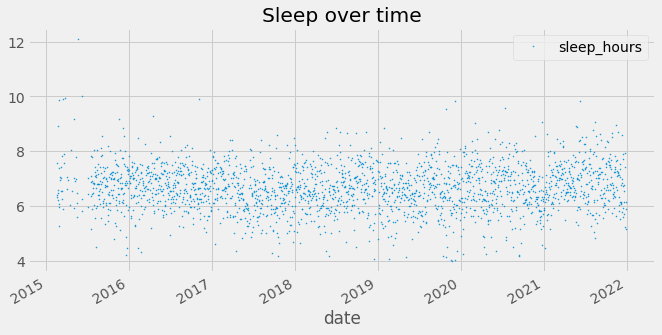

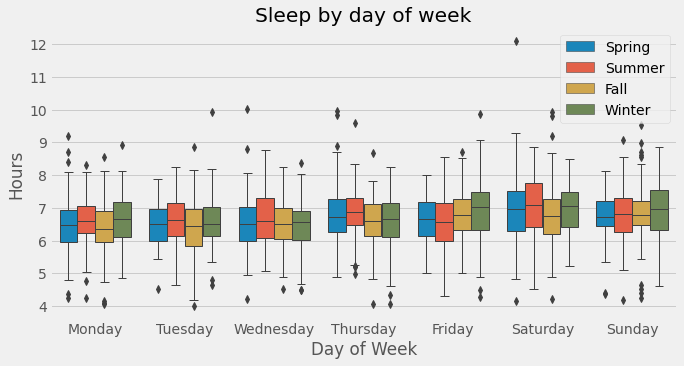

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from pandas.api.types import CategoricalDtype
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

#setting constants
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

#taking in data and doing basic visuals to see our starting point
base_df = pd.read_csv(r'C:\Users\paddy\Documents\Kaggle_competition\downloaded_data\train.csv', index_col=[0], parse_dates=[0])


#getting rid of outliers 
pd.to_datetime(base_df.index)
base_df["sleep_hours"].iloc[833:1090] /= 2 
base_df = base_df[base_df['sleep_hours'] >= 4]


base_df.plot(style='.', figsize=(10,5), ms=1, color=color_pal[0],title='Sleep over time', )
plt.show()

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'], ordered=True)

def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])
    X = df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear','weekday','season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(base_df, label='sleep_hours')
features_and_target = pd.concat([X, y], axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(), x='weekday', y='sleep_hours', hue='season', ax=ax, linewidth=1)
ax.set_title('Sleep by day of week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Hours')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

Train / Test Split #1

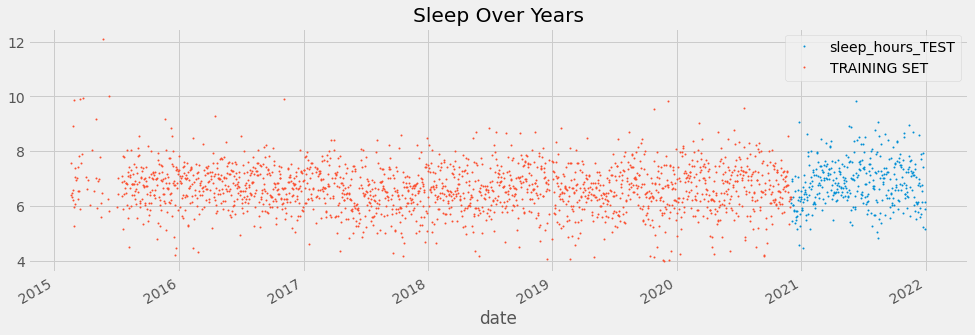

In [35]:
#splitting df into train and test data for model
split_date = '01-DEC-2020'
data_train = base_df.loc[base_df.index <= split_date].copy().add_suffix('_TRAIN')
data_test = base_df.loc[base_df.index > split_date].copy().add_suffix('_TEST')

# Plot data to viz split
data_test.rename(columns={'BASE_DF_TEST': 'TEST SET'}) \
    .join(data_train.rename(columns={'sleep_hours_TRAIN': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15, 5), title='Sleep Over Years', style='.', ms=2)
plt.show()

Modeling #1

14:00:21 - cmdstanpy - INFO - Chain [1] start processing
14:00:21 - cmdstanpy - INFO - Chain [1] done processing


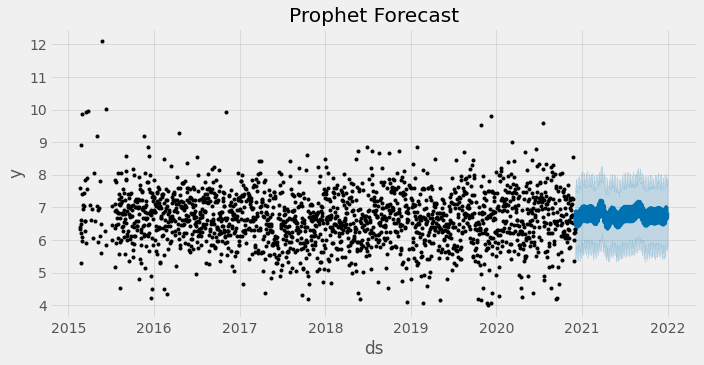

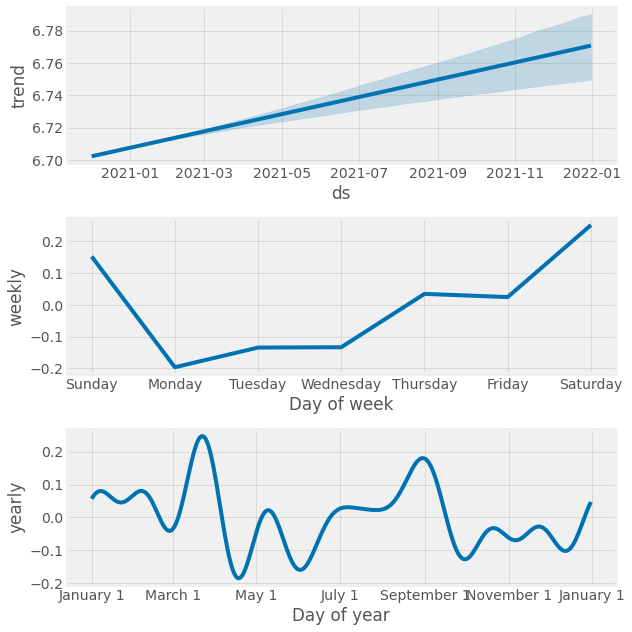

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-12-02,6.702308,5.373174,7.497924,6.702308,6.702308,-0.192704,-0.192704,-0.192704,-0.133207,-0.133207,-0.133207,-0.059497,-0.059497,-0.059497,0.0,0.0,0.0,6.509604
1,2020-12-03,6.702482,5.475824,7.678727,6.702482,6.702482,-0.030640,-0.030640,-0.030640,0.034855,0.034855,0.034855,-0.065494,-0.065494,-0.065494,0.0,0.0,0.0,6.671842
2,2020-12-04,6.702655,5.607533,7.663344,6.702655,6.702655,-0.046746,-0.046746,-0.046746,0.024778,0.024778,0.024778,-0.071524,-0.071524,-0.071524,0.0,0.0,0.0,6.655910
3,2020-12-05,6.702829,5.791022,7.879139,6.702829,6.702829,0.174081,0.174081,0.174081,0.251505,0.251505,0.251505,-0.077424,-0.077424,-0.077424,0.0,0.0,0.0,6.876911
4,2020-12-06,6.703003,5.803171,7.831235,6.703003,6.703003,0.069583,0.069583,0.069583,0.152613,0.152613,0.152613,-0.083030,-0.083030,-0.083030,0.0,0.0,0.0,6.772586


In [36]:
from prophet import Prophet

#renaming df to fit requirements
sleep_train_prophet = data_train.reset_index().rename(columns={'date':'ds','sleep_hours_TRAIN':'y'})

#making model
model = Prophet()
model.fit(sleep_train_prophet)

# Predict on test set with model and renaming for requirements
sleep_test_prophet = data_test.reset_index().rename(columns={'date':'ds','sleep_hours_TRAIN':'y'})
sleep_test_fcst = model.predict(sleep_test_prophet)

#model graph
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(sleep_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

#model components
fig = model.plot_components(sleep_test_fcst)
plt.show()

sleep_test_fcst.head()

Forecast with actuals #1

RMSE = 0.8370563466558867, MAE = 0.6592198013647416, MAPE = 9.6392975484467929


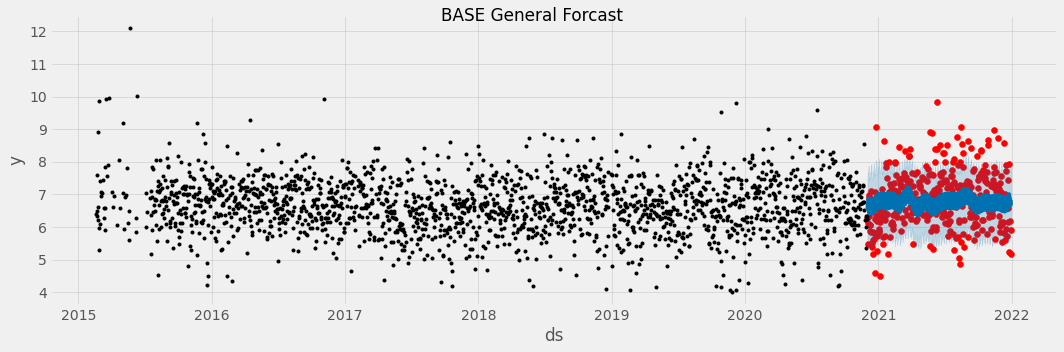

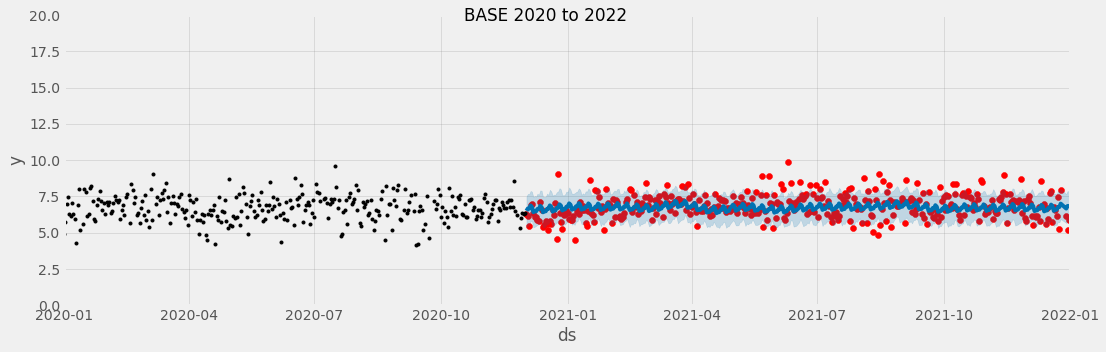

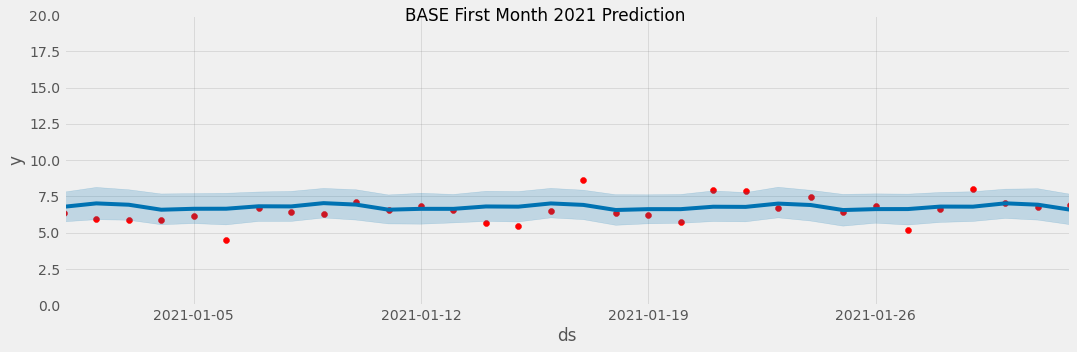

In [37]:
import datetime

#Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test['sleep_hours_TEST'], color='r')
fig = model.plot(sleep_test_fcst, ax=ax)
plot = plt.suptitle('BASE General Forcast')

#2 year view - condensed
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test['sleep_hours_TEST'], color='r')
fig = model.plot(sleep_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.datetime.strptime('2020-01-01', '%Y-%m-%d'),
              upper=datetime.datetime.strptime('2022-01-01', '%Y-%m-%d'))
ax.set_ylim(0, 20)
plot = plt.suptitle('BASE 2020 to 2022')

#one month view
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test['sleep_hours_TEST'], color='r')
fig = model.plot(sleep_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.datetime.strptime('2021-01-01', '%Y-%m-%d'),
              upper=datetime.datetime.strptime('2021-02-01', '%Y-%m-%d'))
ax.set_ylim(0, 20)
plot = plt.suptitle('BASE First Month 2021 Prediction')

print(performance_claculations(y_true=data_test['sleep_hours_TEST'], y_pred=sleep_test_fcst['yhat']))

future = model.make_future_dataframe(periods=1000, freq='d', include_history=False) #change period 
forecast = model.predict(future)
forecast = forecast[['ds','yhat']]
forecast = forecast.rename(columns={'ds': 'date', 'yhat': 'sleep_hours'})
forecast = forecast[(forecast['date'] >= '2022-01-01') & (forecast['date'] <= '2023-03-16')]
exclude_dates = ['2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16', '2022-01-17', '2022-01-18', '2022-02-03', '2022-04-10', '2022-05-10', '2022-06-29', '2022-07-25', '2022-08-09', '2022-08-10', '2022-09-12', '2022-10-17', '2022-12-02', '2022-12-26']
forecast = forecast.loc[~forecast['date'].isin(exclude_dates)]
forecast['date'] = pd.to_datetime(forecast['date'])
forecast['date'] = forecast['date'].dt.strftime('%Y-%m-%d')

forecast.to_csv('base_prophet_outlierex_forecast.csv', index=False)

SEEING IF HOLIDAYS DO ANYTHING #2

14:04:05 - cmdstanpy - INFO - Chain [1] start processing
14:04:05 - cmdstanpy - INFO - Chain [1] done processing


RMSE = 0.8402562223377898, MAE = 0.6601178634313979, MAPE = 9.6465376446544315


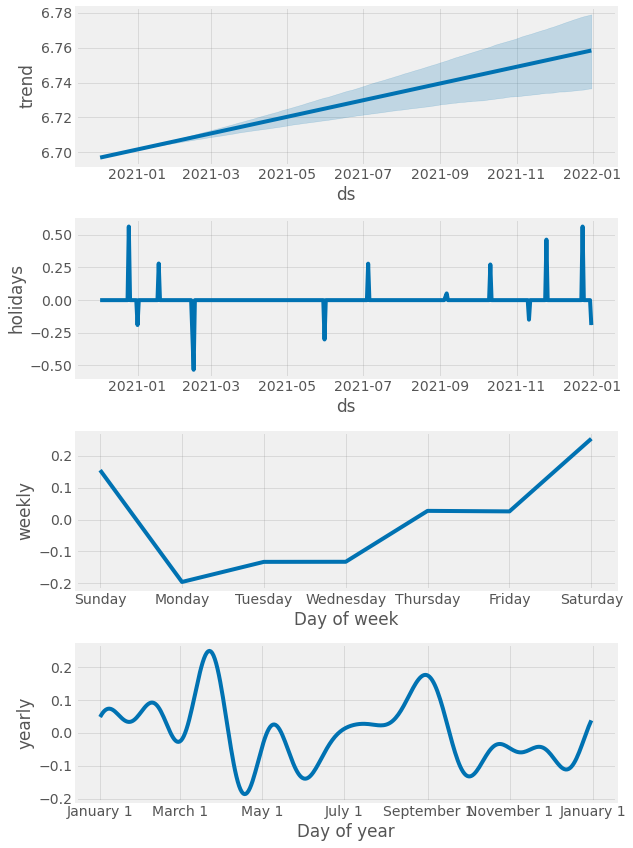

In [117]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

#getting calendar
cal = calendar() 

#getting holidays from cal and creating/naming holiday dataframe
holidays = cal.holidays(start=base_df.index.min(), end=base_df.index.max(), return_name=True)
holiday_df = pd.DataFrame(data=holidays,columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

#model with holidays factored in
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(sleep_train_prophet)

#predicting..
sleep_test_fcst_with_hols = model_with_holidays.predict(df=sleep_test_prophet)

#printing calculations
print(performance_claculations(y_true=data_test['sleep_hours_TEST'], y_pred=sleep_test_fcst_with_hols['yhat']))

#plotting components
fig = model_with_holidays.plot_components(sleep_test_fcst_with_hols)
plt.show()

AVG HEART RATE #3

14:02:13 - cmdstanpy - INFO - Chain [1] start processing
14:02:13 - cmdstanpy - INFO - Chain [1] done processing


RMSE = 4.2793758300764075, MAE = 3.6166979381659390, MAPE = inf


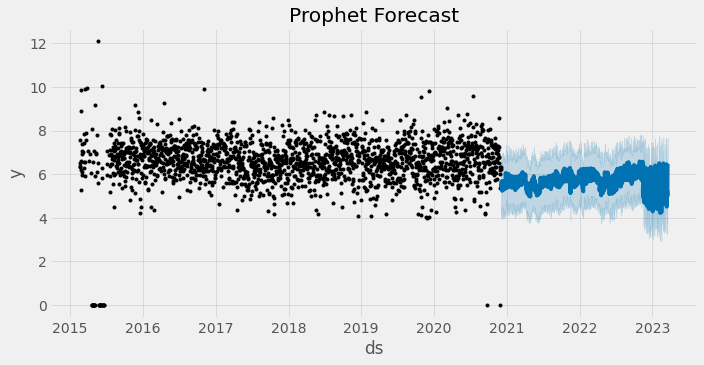

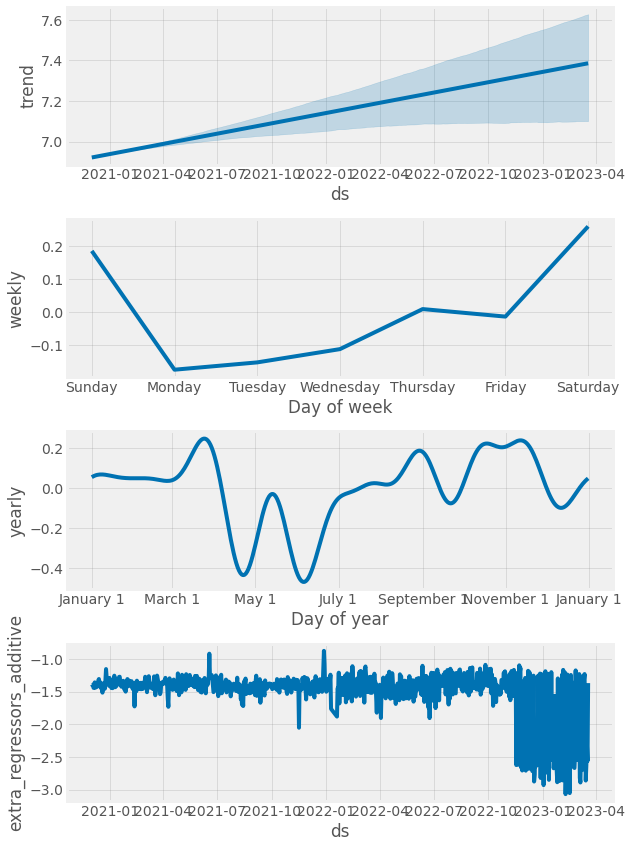

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,y1,y1_lower,y1_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
822,2023-03-14,7.383963,3.251700,5.812995,7.101020,7.624541,-2.870215,-2.870215,-2.870215,-2.860666,...,-2.860666,-2.860666,-2.860666,0.143810,0.143810,0.143810,0.0,0.0,0.0,4.513748
823,2023-03-15,7.384518,3.547301,6.110662,7.100828,7.625300,-2.583333,-2.583333,-2.583333,-2.627575,...,-2.627575,-2.627575,-2.627575,0.157180,0.157180,0.157180,0.0,0.0,0.0,4.801185
824,2023-03-16,7.385074,4.003658,6.538929,7.100817,7.626114,-2.126879,-2.126879,-2.126879,-2.306518,...,-2.306518,-2.306518,-2.306518,0.170633,0.170633,0.170633,0.0,0.0,0.0,5.258195
825,2023-03-17,7.385630,3.788266,6.282681,7.100854,7.627135,-2.390544,-2.390544,-2.390544,-2.560580,...,-2.560580,-2.560580,-2.560580,0.183920,0.183920,0.183920,0.0,0.0,0.0,4.995086
826,2023-03-18,7.386185,5.235183,7.670898,7.100911,7.628156,-0.911420,-0.911420,-0.911420,-1.368903,...,-1.368903,-1.368903,-1.368903,0.196768,0.196768,0.196768,0.0,0.0,0.0,6.474766


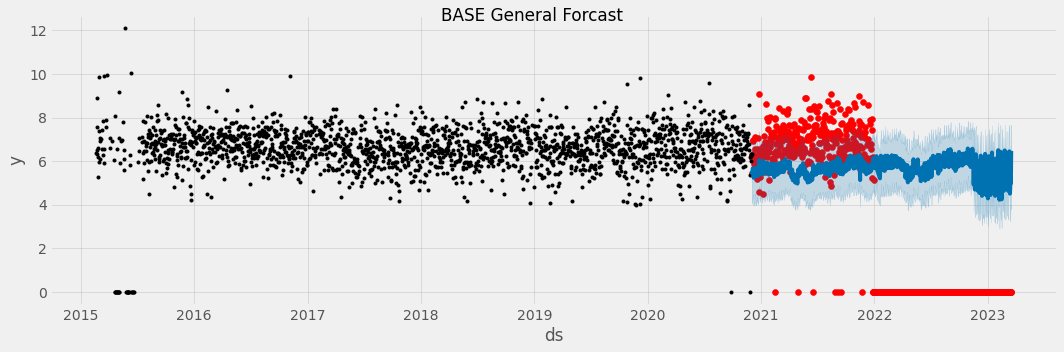

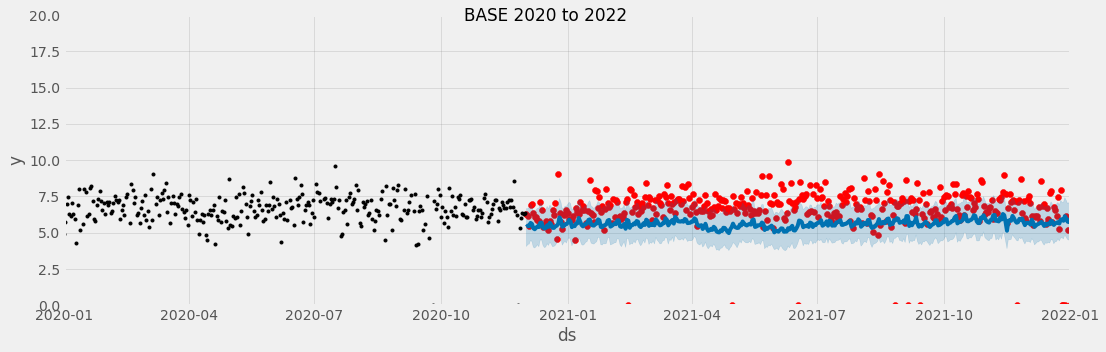

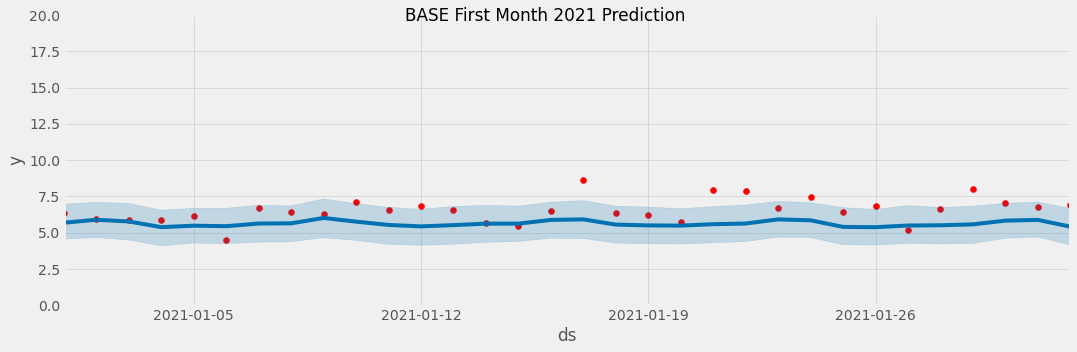

In [40]:
#not fucntioninig / need to know future hr which isnt really plausible for a real model ...on hold
heart_rate_df = pd.read_csv(r'HeartRate.csv', index_col=[0], parse_dates=[0])


# convert endDate to datetime format and only take in day (not hours/minute/seconds)
heart_rate_df['endDate'] = pd.to_datetime(heart_rate_df['endDate'])
heart_rate_df['endDate'] = heart_rate_df['endDate'].dt.date

# group the data by date and calculate the average value amd format tables

avg_heart_rate = heart_rate_df.groupby('endDate')['value'].mean().reset_index() \
            .rename(columns={'endDate':'ds', 'value':'y'})
avg_heart_rate['ds'] = pd.to_datetime(avg_heart_rate['ds'])
avg_heart_rate = avg_heart_rate.set_index('ds')


base_heart_df = base_df.copy()
base_heart_df = base_heart_df[base_heart_df['sleep_hours'] >= 4]

base_heart_df = base_heart_df.reset_index().rename(columns={'date':'ds', 'sleep_hours':'y'}) \
    .set_index('ds')

#doing left join on base_heart_df and making a new df with correct requirements
combined_df = pd.merge(base_heart_df, avg_heart_rate, on='ds', how='outer')
combined_df = combined_df.fillna(0)
combined_df = combined_df.rename(columns={'y_x': 'y', 'y_y': 'y1'})
combined_df = combined_df.loc[combined_df['y1'].notna()]

#splitting data again
split_date = '01-DEC-2020'
data_train = combined_df.loc[combined_df.index <= split_date].copy().add_suffix('_TRAIN')
data_test = combined_df.loc[combined_df.index > split_date].copy().add_suffix('_TEST')
data_train.head()


#renaming df to fit requirements
new_train_data = data_train.reset_index()\
    .rename(columns={'ds':'ds','y_TRAIN':'y','y1_TRAIN':'y1'})
sleep_test_prophet = data_test.reset_index()\
    .rename(columns={'ds':'ds','y_TEST':'y','y1_TEST':'y1'})




#making model
model = Prophet(changepoint_prior_scale=0.05505, seasonality_prior_scale=9, seasonality_mode='additive', changepoint_range=.50)
model = model.add_regressor('y1')
model.fit(new_train_data)
sleep_test_fcst = model.predict(sleep_test_prophet)
sleep_test_fcst.head()

#model calculations
print(performance_claculations(y_true=data_test['y_TEST'], y_pred=sleep_test_fcst['yhat']))


#model graph
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(sleep_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

#model components
fig = model.plot_components(sleep_test_fcst)
plt.show()


# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test['y_TEST'], color='r')
fig = model.plot(sleep_test_fcst, ax=ax)
plot = plt.suptitle('BASE General Forcast')

#2 year view - condensed
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test['y_TEST'], color='r')
fig = model.plot(sleep_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.datetime.strptime('2020-01-01', '%Y-%m-%d'),
              upper=datetime.datetime.strptime('2022-01-01', '%Y-%m-%d'))
ax.set_ylim(0, 20)
plot = plt.suptitle('BASE 2020 to 2022')

#one month view
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test['y_TEST'], color='r')
fig = model.plot(sleep_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.datetime.strptime('2021-01-01', '%Y-%m-%d'),
              upper=datetime.datetime.strptime('2021-02-01', '%Y-%m-%d'))
ax.set_ylim(0, 20)
plot = plt.suptitle('BASE First Month 2021 Prediction')

future = model.make_future_dataframe(periods=804, freq='d', include_history=False)
forecast = model.predict(sleep_test_fcst)
forecast = forecast[['ds','yhat']]
forecast.to_csv('forecast_averageheartrate_prophet.csv', index=False)

PROPHET MODEL WITH CUSTOM TUNINIG #4

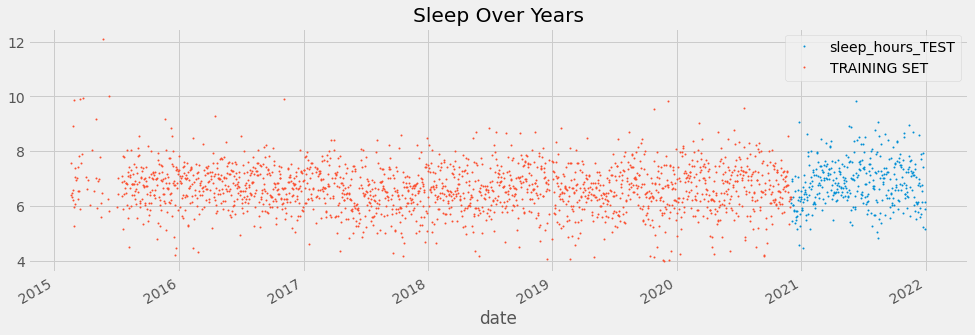

14:07:06 - cmdstanpy - INFO - Chain [1] start processing
14:07:06 - cmdstanpy - INFO - Chain [1] done processing


RMSE = 0.8378795052034405, MAE = 0.6598382085544504, MAPE = 9.6424802659425595


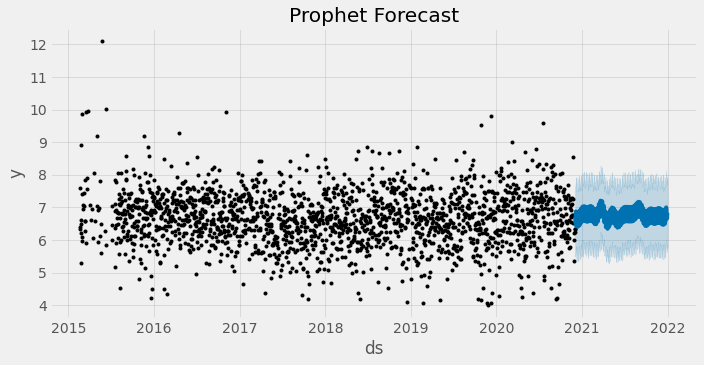

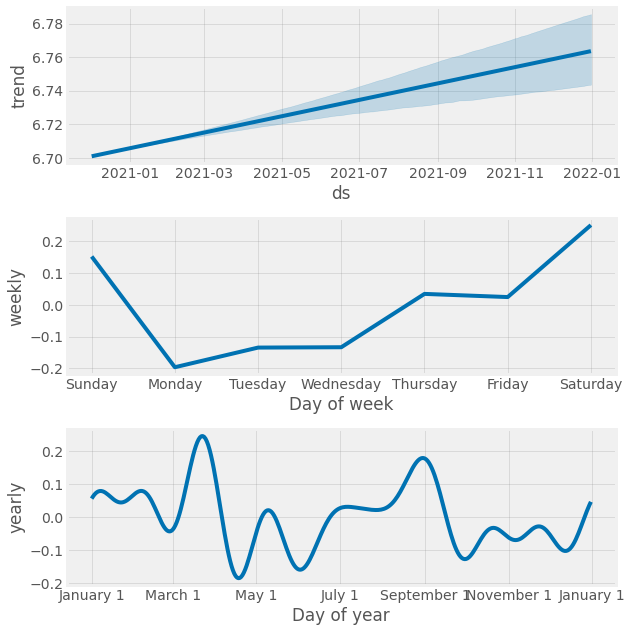

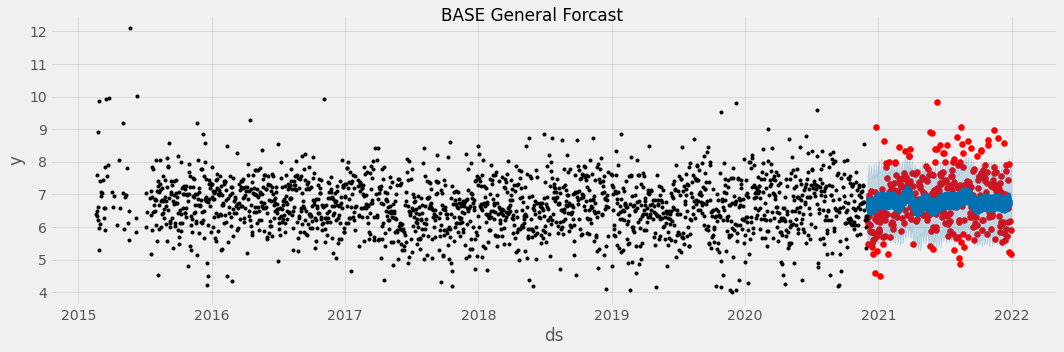

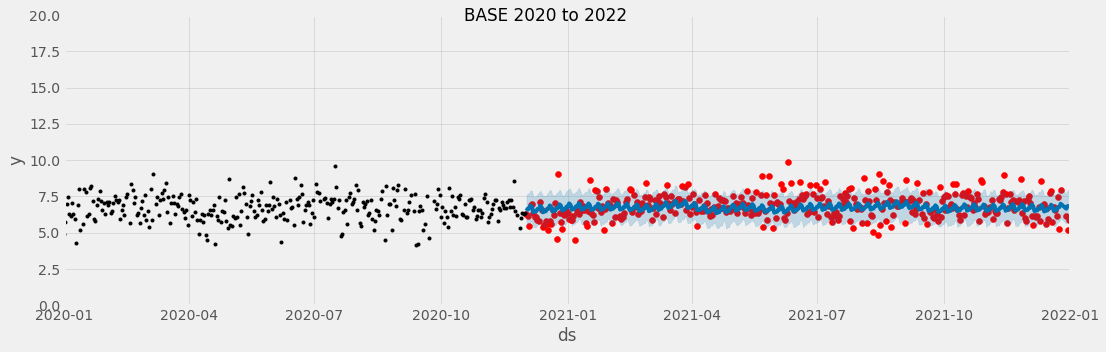

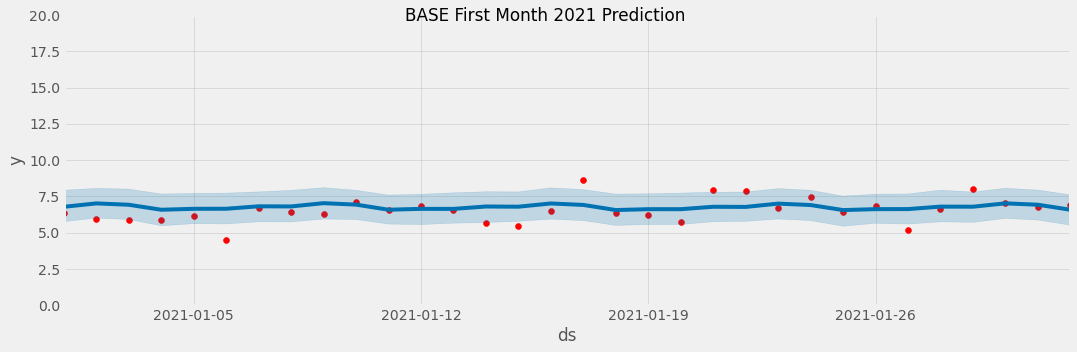

In [41]:
from prophet import Prophet
import datetime

split_date_2 = '01-DEC-2020'
data_train_2 = base_df.loc[base_df.index <= split_date_2].copy().add_suffix('_TRAIN')
data_test_2 = base_df.loc[base_df.index > split_date_2].copy().add_suffix('_TEST')

# Plot train and test so you can see where we have split
data_test_2 \
    .rename(columns={'BASE_DF_TEST': 'TEST SET'}) \
    .join(data_train_2.rename(columns={'sleep_hours_TRAIN': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15, 5), title='Sleep Over Years', style='.', ms=2)
plt.show()

# Format data for prophet model using ds and y
sleep_train_prophet_2 = data_train_2.reset_index() \
    .rename(columns={'date':'ds',
                     'sleep_hours_TRAIN':'y'})
#0551

model = Prophet(changepoint_prior_scale=0.05505, seasonality_prior_scale=9, seasonality_mode='additive', changepoint_range=.50)
model.fit(sleep_train_prophet_2)



# Predict on test set with model
sleep_test_prophet_2 = data_test_2.reset_index() \
    .rename(columns={'date':'ds',
                     'sleep_hours_TRAIN':'y'})

sleep_test_fcst_2 = model.predict(sleep_test_prophet_2)

print(performance_claculations(y_true=data_test_2['sleep_hours_TEST'], y_pred=sleep_test_fcst_2['yhat']))

#model graph
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(sleep_test_fcst_2, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

#model components
fig = model.plot_components(sleep_test_fcst_2)
plt.show()


sleep_test_fcst_2.head()

# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test_2.index, data_test_2['sleep_hours_TEST'], color='r')
fig = model.plot(sleep_test_fcst_2, ax=ax)
plot = plt.suptitle('BASE General Forcast')

#smaller view
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test_2.index, data_test_2['sleep_hours_TEST'], color='r')
fig = model.plot(sleep_test_fcst_2, ax=ax)
ax.set_xbound(lower=datetime.datetime.strptime('2020-01-01', '%Y-%m-%d'),
              upper=datetime.datetime.strptime('2022-01-01', '%Y-%m-%d'))
ax.set_ylim(0, 20)
plot = plt.suptitle('BASE 2020 to 2022')

#even smaller view
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test_2.index, data_test_2['sleep_hours_TEST'], color='r')
fig = model.plot(sleep_test_fcst_2, ax=ax)
ax.set_xbound(lower=datetime.datetime.strptime('2021-01-01', '%Y-%m-%d'),
              upper=datetime.datetime.strptime('2021-02-01', '%Y-%m-%d'))
ax.set_ylim(0, 20)
plot = plt.suptitle('BASE First Month 2021 Prediction')

##______________________________________________
future = model.make_future_dataframe(periods=1000, freq='d', include_history=False) #783 for 2021 splitdate
forecast = forecast.rename(columns={'ds': 'date', 'yhat': 'sleep_hours'})
forecast = forecast[(forecast['date'] >= '2022-01-01') & (forecast['date'] <= '2023-03-16')]
exclude_dates = ['2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16', '2022-01-17', '2022-01-18', '2022-02-03', '2022-04-10', '2022-05-10', '2022-06-29', '2022-07-25', '2022-08-09', '2022-08-10', '2022-09-12', '2022-10-17', '2022-12-02', '2022-12-26']
forecast = forecast.loc[~forecast['date'].isin(exclude_dates)]

forecast.to_csv('modded_prophet_outlierex_forecast.csv', index=False)

  0%|          | 0/4 [00:00<?, ?it/s]

13:49:10 - cmdstanpy - INFO - Chain [1] start processing
13:49:10 - cmdstanpy - INFO - Chain [1] done processing
13:49:10 - cmdstanpy - INFO - Chain [1] start processing
13:49:10 - cmdstanpy - INFO - Chain [1] done processing
13:49:11 - cmdstanpy - INFO - Chain [1] start processing
13:49:11 - cmdstanpy - INFO - Chain [1] done processing
13:49:11 - cmdstanpy - INFO - Chain [1] start processing
13:49:11 - cmdstanpy - INFO - Chain [1] done processing


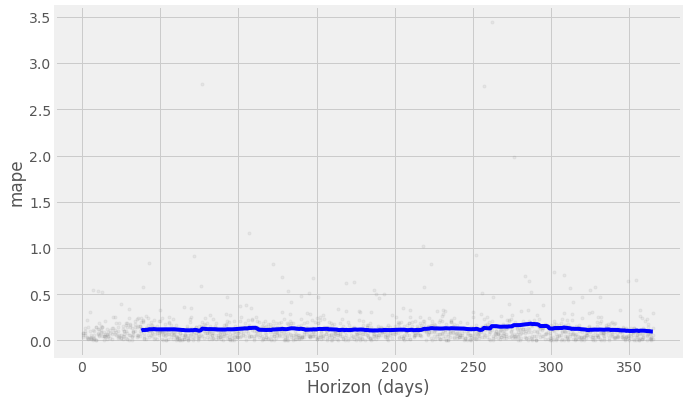

In [69]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric



sleep_train_prophet_2_cv = cross_validation(model, initial='1095 days', period='180 days', horizon='365 days')
sleep_train_prophet_2_cv.head()
df_p = performance_metrics(sleep_train_prophet_2_cv)
fig = plot_cross_validation_metric(sleep_train_prophet_2_cv, metric='mape')

XGBOOST #5 "EXTRA"

[16:16:35] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.51069	validation_1-rmse:6.79224
[100]	validation_0-rmse:2.52572	validation_1-rmse:2.78750
[200]	validation_0-rmse:1.23560	validation_1-rmse:1.44646
[300]	validation_0-rmse:0.92760	validation_1-rmse:1.04018
[400]	validation_0-rmse:0.87232	validation_1-rmse:0.92185
[500]	validation_0-rmse:0.85899	validation_1-rmse:0.88648
[600]	validation_0-rmse:0.85238	validation_1-rmse:0.87415
[700]	validation_0-rmse:0.84789	validation_1-rmse:0.87000
[800]	validation_0-rmse:0.84367	validation_1-rmse:0.86897
[812]	validation_0-rmse:0.84307	validation_1-rmse:0.86878


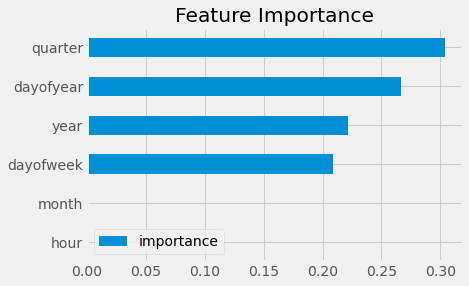

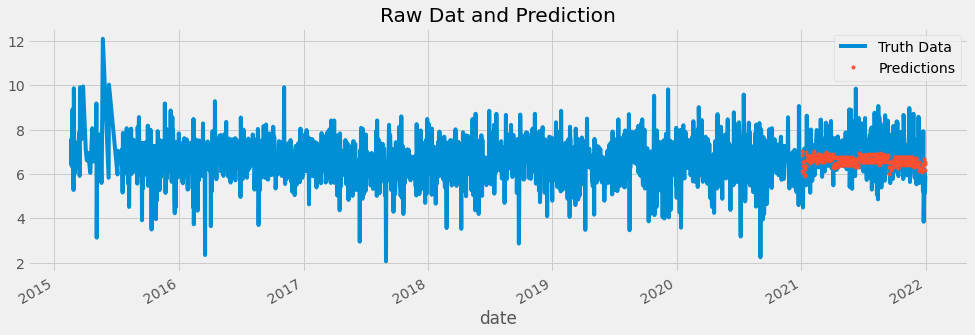

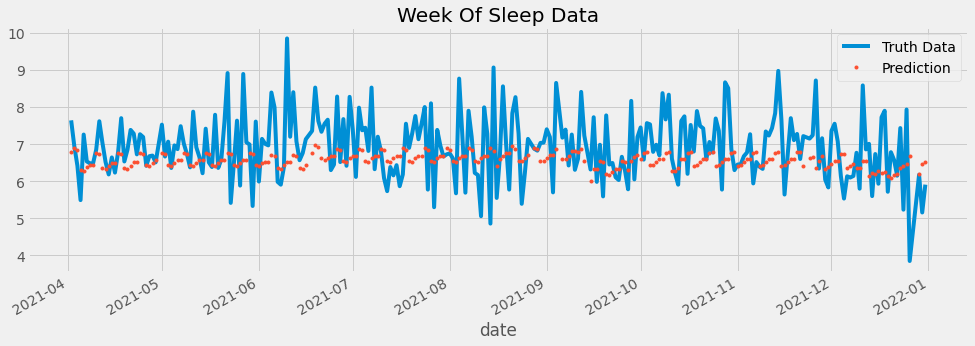

RMSE Score on Test set: 0.86869608


date
2021-06-10    3.344690
2021-12-26    2.821772
2021-11-26    2.346612
2021-05-27    2.314278
2021-08-15    2.242776
2021-11-14    2.185923
2021-08-04    2.150899
2021-05-22    2.147132
2021-10-28    2.063371
2021-12-11    2.034254
Name: error, dtype: float64

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

pd.to_datetime(base_df.index)

def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    df['sleep_hours'] = df['sleep_hours']
    X = df[['hour','dayofweek','quarter','month','year',
        'dayofyear','dayofmonth','weekofyear','weekday',
        'season', 'sleep_hours']]
    if label:
        y = df[label]
        return X, y
    return X

base_df_2 = create_features(base_df)
base_df_2 = base_df_2[base_df_2['sleep_hours'] >= 2]

split_date = '1-JAN-2021'
train = base_df_2.loc[base_df_2.index <= split_date].copy()
test = base_df_2.loc[base_df_2.index > split_date].copy()

train = create_features(train)
test = create_features(test)




FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'sleep_hours'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.1, booster='gbtree',    
                       n_estimators=3000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

test['prediction'] = reg.predict(X_test)
df = base_df_2.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['sleep_hours']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

ax = df.loc[(df.index > '04-01-2021') & (df.index < '01-01-2022')]['sleep_hours'] \
    .plot(figsize=(15, 5), title='Week Of Sleep Data') 

df.loc[(df.index > '04-01-2021') & (df.index < '01-01-2022')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

score = np.sqrt(mean_squared_error(test['sleep_hours'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.8f}')



test['error'] = np.abs(test[TARGET] - test['prediction'])
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)



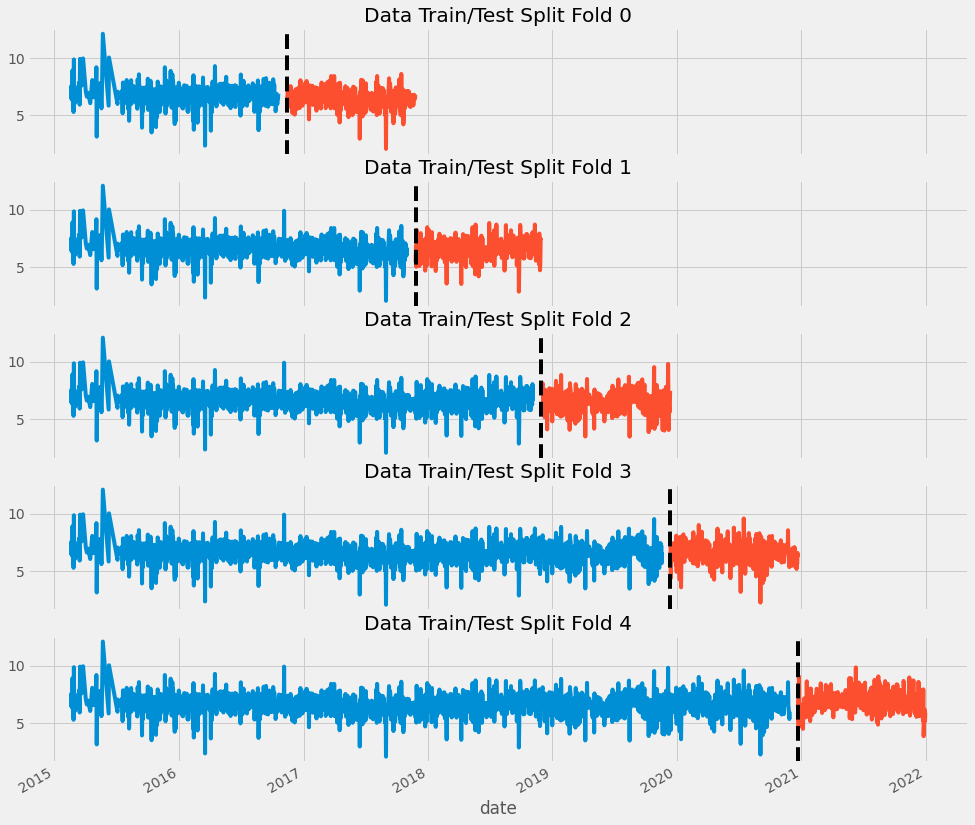

In [29]:
from sklearn.model_selection import TimeSeriesSplit

base_df_3 = base_df.copy  

tss = TimeSeriesSplit(n_splits=5, test_size=1*365, gap=24)

base_df_3 = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(base_df_3):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['sleep_hours'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['sleep_hours'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()


In [38]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

 
tweaked_data = create_features(base_df_3)
tweaked_data = tweaked_data[tweaked_data['sleep_hours'] >= 2]

def add_lags(df):
    target_map = df['sleep_hours'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

lagged_data = add_lags(tweaked_data)



tss = TimeSeriesSplit(n_splits=5, test_size=365*1, gap=24)
lagged_data = lagged_data.sort_index()


fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(lagged_data):
    train = lagged_data.iloc[train_idx]
    test = lagged_data.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'sleep_hours'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.1, booster='gbtree',    
                           n_estimators=500,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

# Retrain on all data
lagged_data = create_features(lagged_data)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'sleep_hours'

X_all = lagged_data[FEATURES]
y_all = lagged_data[TARGET]

reg = xgb.XGBRegressor(base_score=0.1,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[16:39:31] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.64961	validation_1-rmse:6.39824
[100]	validation_0-rmse:2.58244	validation_1-rmse:2.33564
[200]	validation_0-rmse:1.24791	validation_1-rmse:1.11585
[300]	validation_0-rmse:0.90527	validation_1-rmse:0.90160
[395]	validation_0-rmse:0.83492	validation_1-rmse:0.89390
[16:39:32] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.55248	validation_1-rmse:6.49293
[100]	validation_0-rmse:2.53936	validation_1-rmse:2.53811
[200]	validation_0-rmse:1.22241	validation_1-rmse:1.31248
[300]	validation_0-rmse:0.89325	validation_1-rmse:0.99665
[400]	validation_0-rmse:0.82959	validation_1-rmse:0.93417
[499]	validation_0-rmse:0.81357	validation_1-rmse:0.92579
[16:39:32] WARNI

XGBRegressor(base_score=0.1, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

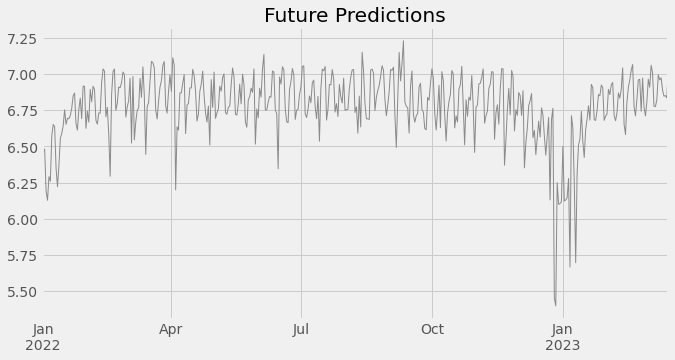

In [39]:
df.index.max()

# Create future dataframe
future = pd.date_range('2021-12-31','2023-03-16', freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

future_w_features.to_csv('xgboosttest.csv',index=False)